In [ ]:
!pip install transformers
!pip install -U datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from collections import defaultdict, Counter
import json
import numpy as np
import torch
import pandas as pd

from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from torch.optim import AdamW
from transformers import set_seed
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_results.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TEST.csv')
# train = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Base/BERTopic_TRAIN_80.csv')
# validation = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Base/BERTopic_VAL_20.csv')

# turning into hugging face format
# test = Dataset.from_pandas(test)
# train = Dataset.from_pandas(train)
# validation = Dataset.from_pandas(validation)

# New Way of Choosing Data

In [ ]:
from sklearn.model_selection import train_test_split
dominant_topic_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/dominant_topic_results.csv')

# Assuming dominant_topic_df is the DataFrame you want to split
# Define the features (X) and the target (y)
# Here, we'll use the 'Text' column as the feature
X = dominant_topic_df['Text']

# And the topic probability columns and Dominant_Topic as the target (y)
# Changed to include Topic_0 through Topic_5 instead of the percentage columns
topic_columns = [col for col in dominant_topic_df.columns if col.startswith('Topic_') and len(col) == 7 and not col.endswith('_Perc')]
y = dominant_topic_df[['Document_Num'] + topic_columns]


# Perform the 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,  # 20% for validation
    random_state=random_seed # Use the predefined random_seed for reproducibility
    # Stratify is not directly applicable to multi-output targets like this,
    # so we will remove it.
)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("\nShape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Training set size: 309
Validation set size: 78

Shape of X_train: (309,)
Shape of X_val: (78,)
Shape of y_train: (309, 7)
Shape of y_val: (78, 7)


In [159]:
test_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv')

test_df = test_df[['pk', 'summary', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', "Topic_5"]]
display(test_df.head())

KeyError: "['summary', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5'] not in index"

In [ ]:
# Tokenizing
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
name = "bert-base-uncased"
tokenizer_length = 512

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Train and Validation

# Convert pandas Series to datasets.Dataset for easier mapping
# Exclude 'Document_Num' from labels for training and validation sets
topic_columns = [col for col in dominant_topic_df.columns if col.startswith('Topic_') and len(col) == 7 and not col.endswith('_Perc')]
topic_columns_test = [col for col in test_df.columns if col.startswith('GPT_Topic_') and len(col) == 10 and not col.endswith('_Perc')]
train_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_train, 'labels': y_train[topic_columns].values.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_val, 'labels': y_val[topic_columns].values.tolist()}))

# Apply tokenization using map
tokenized_train = train_dataset.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length),
    batched=True
)

# Remove the original text column (we don't need it after tokenization)
tokenized_train = tokenized_train.remove_columns(['Text'])

# Set format to torch tensors
tokenized_train.set_format("torch")

# Check the results
print("Tokenized training dataset features:", tokenized_train.column_names)
print("Training dataset size:", len(tokenized_train))
print("\nSample training data shapes:")
print(f"- input_ids: {tokenized_train[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_train[0]['attention_mask'].shape}")
print(f"- labels shape: {tokenized_train[0]['labels'].shape}")
print(f"- labels type: {type(tokenized_train[0]['labels'])}")


tokenized_validation = val_dataset.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length,),
    batched=True
)

tokenized_validation = tokenized_validation.remove_columns(['Text'])

tokenized_validation.set_format("torch")

print("\nTokenized validation dataset size:", len(tokenized_validation))
print("Sample validation data shapes:")
print(f"- input_ids: {tokenized_validation[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_validation[0]['attention_mask'].shape}")
print(f"- labels shape: {tokenized_validation[0]['labels'].shape}")
print(f"- labels type: {type(tokenized_validation[0]['labels'])}")


# Test
# Separate features and labels for the test set
# Use 'summary' as the text feature and the multi-hot encoded topics as the labels
X_test = test_df['summary']
# Convert the multi-hot encoded topic labels to a list of lists
y_test_labels_list = test_df[topic_columns_test].values.tolist()
test_pk = test_df['pk'] # Keep 'pk' separately

test_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_test, 'labels': y_test_labels_list, 'pk': test_pk}))

tokenized_test = test_dataset.map(
     lambda example: tokenizer(example['Text'],
                              padding="max_length",
                              truncation=True,
                              max_length=tokenizer_length),
    batched=True
)

tokenized_test = tokenized_test.remove_columns(['Text'])
tokenized_test.set_format("torch")

print("\nTokenized test dataset size:", len(tokenized_test))
print("Sample test data shapes:")
print(f"- input_ids: {tokenized_test[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_test[0]['attention_mask'].shape}")
# The labels for the test set are now the multi-hot encoded labels
print(f"- labels: {tokenized_test[0]['labels']}")
print(f"- labels type: {type(tokenized_test[0]['labels'])}")
print(f"- pk: {tokenized_test[0]['pk']}")
print(f"- pk type: {type(tokenized_test[0]['pk'])}")

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Tokenized training dataset features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
Training dataset size: 309

Sample training data shapes:
- input_ids: torch.Size([512])
- attention_mask: torch.Size([512])
- labels shape: torch.Size([6])
- labels type: <class 'torch.Tensor'>


Map:   0%|          | 0/78 [00:00<?, ? examples/s]


Tokenized validation dataset size: 78
Sample validation data shapes:
- input_ids: torch.Size([512])
- attention_mask: torch.Size([512])
- labels shape: torch.Size([6])
- labels type: <class 'torch.Tensor'>


Map:   0%|          | 0/167 [00:00<?, ? examples/s]


Tokenized test dataset size: 167
Sample test data shapes:
- input_ids: torch.Size([512])
- attention_mask: torch.Size([512])
- labels: []
- labels type: <class 'list'>
- pk: 431
- pk type: <class 'torch.Tensor'>


In [ ]:
batch_size = 4 # Base is 4
train_dataset = tokenized_train.shuffle(seed=1111).select(range(309))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_validation, batch_size=batch_size)

In [ ]:
model_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/DistilBERT_Saved_Models/DistilBERT '
model_name = "bert-base-uncased"

In [ ]:
set_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
          "bert-base-uncased",
          num_labels=6,
          hidden_dropout_prob=0.4,
          attention_probs_dropout_prob=0.4
      ).to(device)

num_epochs = 50
num_training_steps = len(train_dataloader) * num_epochs

# optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
optimizer = AdamW(model.parameters(), lr=1.52e-05, weight_decay=0.18,)  # Halved Learning Rate

# lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.113 * num_training_steps),  # 10% warmup
    num_training_steps=num_training_steps
)

# Use BCEWithLogitsLoss for multi-label classification
loss_fct = torch.nn.BCEWithLogitsLoss()

# For Graph
x_epochs = []
y_train = []
y_val = []

best_val_loss = float("inf")

early_stopping = True
early_count = 0 # +1 every time validation loss doesnt improve
early_limit = 5

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    x_epochs.append(epoch)

    # training
    model.train()
    training_losses = []
    for batch_i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Convert labels to float and move to device
        labels = batch['labels'].to(device).float()


        # output = model(**batch)
        # Pass input_ids and attention_mask to the model
        output = model(input_ids, attention_mask=attention_mask)
        # Calculate loss using BCEWithLogitsLoss
        training_loss = loss_fct(output.logits, labels)

        training_losses.append(training_loss.item())

        #backprop and update params by taking an optimization step
        training_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    print(f"\nEpoch {epoch}:")
    print("Mean Training Loss", np.mean(training_losses))
    y_train.append(np.mean(training_losses))

    # validation
    val_loss = 0
    model.eval() #important to call because we dont want to collect gradients
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            # copy input to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Convert labels to float and move to device
            labels = batch['labels'].to(device).float()
            # output = model(**batch)
            # Pass input_ids and attention_mask to the model
            output = model(input_ids, attention_mask=attention_mask)

        # Calculate loss using BCEWithLogitsLoss
        val_loss += loss_fct(output.logits, labels)


    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    y_val.append(avg_val_loss.cpu())

    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        early_count = 0 # Reset counter
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"{model_path}best_model.pt"
        )
    elif early_stopping:
        early_count += 1

        if early_count == early_limit:
            print(f"Validation loss has not improved for {early_limit} iterations; Early Stopping.")
            break

    print()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3900 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Epoch 0:
Mean Training Loss 0.6848364480030842
Validation loss: 0.6738235354423523
Saving checkpoint!


Epoch 1:
Mean Training Loss 0.6335286620335702
Validation loss: 0.6002517342567444
Saving checkpoint!


Epoch 2:
Mean Training Loss 0.5454429961167849
Validation loss: 0.5242652893066406
Saving checkpoint!


Epoch 3:
Mean Training Loss 0.5032056012214758
Validation loss: 0.49359330534935
Saving checkpoint!


Epoch 4:
Mean Training Loss 0.4975788532159267
Validation loss: 0.4867234230041504
Saving checkpoint!


Epoch 5:
Mean Training Loss 0.48632168502379686
Validation loss: 0.4826236665248871
Saving checkpoint!


Epoch 6:
Mean Training Loss 0.4766169454042728
Validation loss: 0.47513100504875183
Saving checkpoint!


Epoch 7:
Mean Training Loss 0.4532496478313055
Validation loss: 0.438098281621933
Saving checkpoint!


Epoch 8:
Mean Training Loss 0.4086726991794048
Validation loss: 0.4188522398471832
Saving checkpoint!


Epoch 9:
Mean Training Loss 0.37445234067929095
Validation loss:

Text(0.5, 0, 'Epochs')

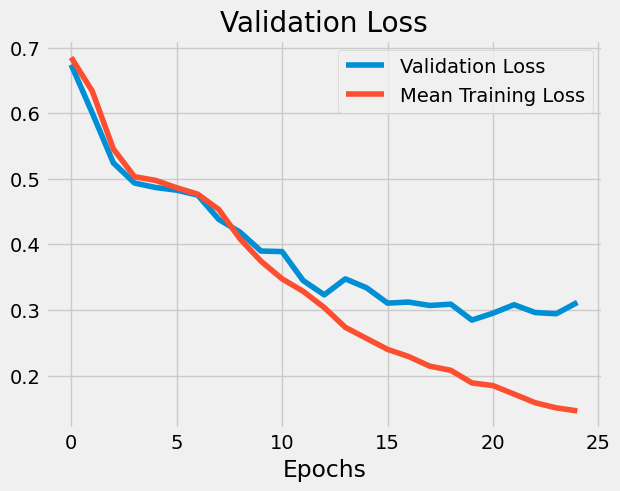

In [ ]:
plt.plot(x_epochs, y_val, label="Validation Loss")
plt.plot(x_epochs, y_train, label="Mean Training Loss")
plt.legend()
plt.style.use('fivethirtyeight')
plt.title("Validation Loss")
plt.xlabel("Epochs")

In [ ]:
# Load the best model
best_model_path = f"{model_path}best_model.pt"
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() # Set the model to evaluation mode

# Create a DataLoader for the test set
test_dataloader = DataLoader(tokenized_test, batch_size=batch_size)

predictions = []
pk_values = [] # To store pk values

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Predicting on test data"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Move pk to CPU and convert to numpy
        pk = batch['pk'].cpu().numpy()
        pk_values.extend(pk)


        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        predictions.extend(probs.cpu().numpy())

# Convert predictions to a DataFrame
prediction_df = pd.DataFrame(predictions, columns=[f'Topic_{i}_Prob' for i in range(6)])

# Add the original text and pk back to the prediction DataFrame
# We need to get the original text and pk from the test_df or tokenized_test dataset
# Since tokenized_test has 'pk' and we can get 'summary' from test_df using 'pk'
# Let's create a mapping from pk to summary from the original test_df
pk_to_text = test_df.set_index('pk')['summary'].to_dict()

# Add 'pk' and 'summary' to the prediction_df
prediction_df['pk'] = pk_values # Use the collected numpy array of pk values
prediction_df['summary'] = prediction_df['pk'].map(pk_to_text)

# Rearrange columns to have pk and summary first
cols = ['pk', 'summary'] + [col for col in prediction_df.columns if col not in ['pk', 'summary']]
prediction_df = prediction_df[cols]

display(prediction_df.head())

Predicting on test data:   0%|          | 0/42 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,pk,summary,Topic_0_Prob,Topic_1_Prob,Topic_2_Prob,Topic_3_Prob,Topic_4_Prob,Topic_5_Prob
0,431,"In July 2020, Cargill received a grievance aga...",0.045934,0.016488,0.536381,0.170092,0.044312,0.095197
1,432,A grievance was filed against Agropalma regard...,0.209596,0.008083,0.141076,0.025238,0.188519,0.069584
2,433,This grievance was filed by Friends of the Ear...,0.737022,0.011786,0.082940,0.019650,0.093320,0.151647
3,434,A grievance was filed against Brasil Bio Fuels...,0.072884,0.020863,0.129042,0.060368,0.716407,0.026741
4,435,A grievance was filed by Link-Ar Borneo agains...,0.082658,0.016878,0.191286,0.125021,0.365638,0.030812


In [ ]:
test_df.head()

,pk,summary,GPT_Topic_0,GPT_Topic_1,GPT_Topic_2,GPT_Topic_3,GPT_Topic_4,GPT_Topic_5
0,431,"In July 2020, Cargill received a grievance aga...",1,1,1,1,0,0
1,432,A grievance was filed against Agropalma regard...,1,0,1,1,1,0
2,433,This grievance was filed by Friends of the Ear...,1,1,0,0,0,0
3,434,A grievance was filed against Brasil Bio Fuels...,0,0,1,1,1,0
4,435,A grievance was filed by Link-Ar Borneo agains...,0,1,0,0,0,0


In [ ]:
prediction_df

,pk,summary,Topic_0_Prob,Topic_1_Prob,Topic_2_Prob,Topic_3_Prob,Topic_4_Prob,Topic_5_Prob
0,431,"In July 2020, Cargill received a grievance aga...",0.045934,0.016488,0.536381,0.170092,0.044312,0.095197
1,432,A grievance was filed against Agropalma regard...,0.209596,0.008083,0.141076,0.025238,0.188519,0.069584
2,433,This grievance was filed by Friends of the Ear...,0.737022,0.011786,0.082940,0.019650,0.093320,0.151647
3,434,A grievance was filed against Brasil Bio Fuels...,0.072884,0.020863,0.129042,0.060368,0.716407,0.026741
4,435,A grievance was filed by Link-Ar Borneo agains...,0.082658,0.016878,0.191286,0.125021,0.365638,0.030812
...,...,...,...,...,...,...,...,...
162,596,A grievance has been filed against PT ASM rega...,0.017229,0.054062,0.329728,0.336906,0.031850,0.084966
163,597,The grievance concerns PT SIL & SIP (Sebakis I...,0.022244,0.034185,0.394779,0.161128,0.011747,0.163181
164,598,The grievance involves a report by Rainforest ...,0.037518,0.055457,0.241425,0.128713,0.078507,0.052110
165,599,This grievance concerns the deforestation of T...,0.027604,0.243851,0.113309,0.198065,0.034503,0.056390


In [156]:
from sklearn.metrics import accuracy_score, f1_score

# Define the threshold for converting probabilities to binary labels
evaluation_threshold = 0.3

# Get the predicted probabilities for the topic columns from prediction_df
# Corrected pattern to match 'Topic_' and end with '_Prob'
topic_prob_columns = [col for col in prediction_df.columns if col.startswith('Topic_') and col.endswith('_Prob')]
predicted_probs = prediction_df[topic_prob_columns].values

# Convert probabilities to binary predictions using the threshold
binary_predictions = (predicted_probs >= evaluation_threshold).astype(int)

# Get the true multi-hot encoded labels from test_df
# Ensure alignment with prediction_df based on 'pk'
# Assuming test_df contains 'pk' and 'Topic_0' through 'Topic_5'
# Corrected to look for 'GPT_Topic_' columns in test_df
true_labels_for_eval = pd.merge(prediction_df[['pk']], test_df[['pk'] + [f'GPT_Topic_{i}' for i in range(6)]], on='pk', how='left')

# Extract the true labels in the correct order
true_labels_values = true_labels_for_eval[[f'GPT_Topic_{i}' for i in range(6)]].values

# Create a DataFrame for binary predictions (optional, but requested)
binary_prediction_df = pd.DataFrame(binary_predictions, columns=[f'Topic_{i}' for i in range(6)])
# Add pk for potential merging or inspection
binary_prediction_df['pk'] = prediction_df['pk']
# Rearrange columns
cols = ['pk'] + [col for col in binary_prediction_df.columns if col != 'pk']
binary_prediction_df = binary_prediction_df[cols]

# Display the head of the binary predictions DataFrame
print("Binary Predictions (first 5 rows):")
display(binary_prediction_df.head())

# Calculate Overall Accuracy and Micro F1 Score
overall_accuracy = accuracy_score(true_labels_values, binary_predictions)
overall_f1_micro = f1_score(true_labels_values, binary_predictions, average='micro')


print(f"\nOverall Evaluation Results (Threshold = {evaluation_threshold}):")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Micro F1 Score: {overall_f1_micro:.4f}")


# Calculate Accuracy and F1 Score for each label
print("\nEvaluation Results per Label (Threshold =", evaluation_threshold, "):")
for i in range(6):
    topic_col_name = f'Topic_{i}'
    # Accuracy for the current label
    accuracy = accuracy_score(true_labels_values[:, i], binary_predictions[:, i])
    # F1 score for the current label
    f1 = f1_score(true_labels_values[:, i], binary_predictions[:, i])

    print(f"{topic_col_name}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}")

# Note: You can easily change the 'evaluation_threshold' variable above and re-run this cell
# to see the impact on accuracy and F1 score for each label.

Binary Predictions (first 5 rows):


,pk,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,431,0,0,1,0,0,0
1,432,0,0,0,0,0,0
2,433,1,0,0,0,0,0
3,434,0,0,0,0,1,0
4,435,0,0,0,0,1,0



Overall Evaluation Results (Threshold = 0.3):
Accuracy: 0.0359
Micro F1 Score: 0.4589

Evaluation Results per Label (Threshold = 0.3 ):
Topic_0: Accuracy = 0.6168, F1 Score = 0.2195
Topic_1: Accuracy = 0.2275, F1 Score = 0.1342
Topic_2: Accuracy = 0.5090, F1 Score = 0.6019
Topic_3: Accuracy = 0.5808, F1 Score = 0.6569
Topic_4: Accuracy = 0.8743, F1 Score = 0.5116
Topic_5: Accuracy = 0.9461, F1 Score = 0.0000



Evaluation per Topic (Threshold = 0.3 ):
------------------------------------------------------------
Topic_0: Correctly Classified = 103, Total Instances = 167, Percentage Correct = 61.68%, F1 Score = 0.2195
Topic_1: Correctly Classified = 38, Total Instances = 167, Percentage Correct = 22.75%, F1 Score = 0.1342
Topic_2: Correctly Classified = 85, Total Instances = 167, Percentage Correct = 50.90%, F1 Score = 0.6019
Topic_3: Correctly Classified = 97, Total Instances = 167, Percentage Correct = 58.08%, F1 Score = 0.6569
Topic_4: Correctly Classified = 146, Total Instances = 167, Percentage Correct = 87.43%, F1 Score = 0.5116
Topic_5: Correctly Classified = 158, Total Instances = 167, Percentage Correct = 94.61%, F1 Score = 0.0000
------------------------------------------------------------


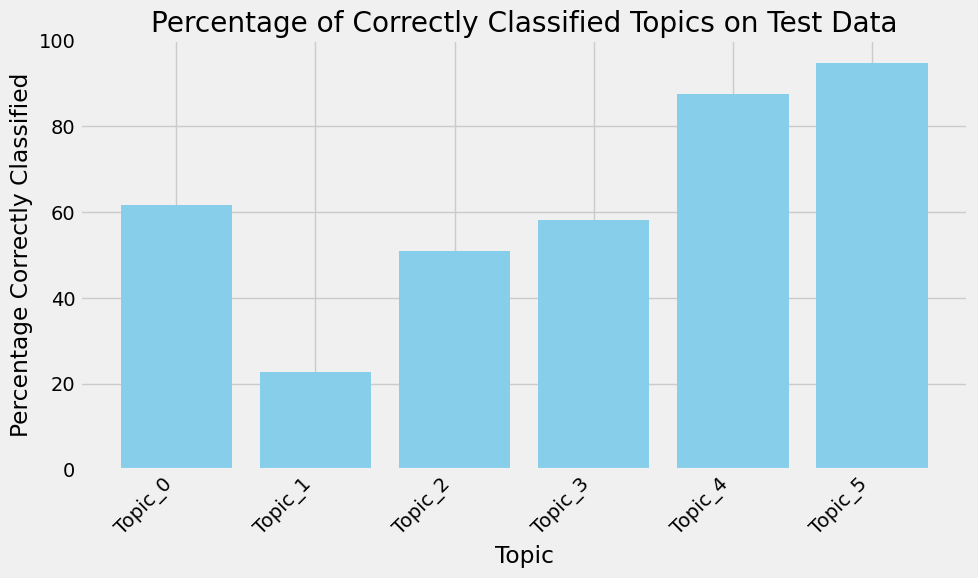

In [ ]:
# Calculate the number of correctly classified topics for each topic
correctly_classified_counts = {}
total_instances_per_topic = np.sum(true_labels_values, axis=0) # Total true instances for each topic

print("\nEvaluation per Topic (Threshold =", evaluation_threshold, "):")
print("------------------------------------------------------------")

for i in range(6):
    topic_col_name = f'Topic_{i}'
    # Count where binary prediction matches true label for the current topic
    correct_predictions_for_topic = np.sum(binary_predictions[:, i] == true_labels_values[:, i])
    correctly_classified_counts[topic_col_name] = correct_predictions_for_topic

    # Calculate percentage of correctly classified instances for this topic
    # This is the overall accuracy for this specific binary classification task
    total_instances = len(true_labels_values) # Total number of documents
    percentage_correct = (correct_predictions_for_topic / total_instances) * 100

    # Calculate F1 Score for the current label
    f1 = f1_score(true_labels_values[:, i], binary_predictions[:, i])


    print(f"{topic_col_name}: Correctly Classified = {correct_predictions_for_topic}, Total Instances = {total_instances}, Percentage Correct = {percentage_correct:.2f}%, F1 Score = {f1:.4f}")

print("------------------------------------------------------------")

# Create a bar chart to visualize the percentage of correctly classified instances per topic
topics = list(correctly_classified_counts.keys())
# Recalculate percentages for plotting as it was not explicitly stored
percentages = [(correctly_classified_counts[topic] / len(true_labels_values)) * 100 for topic in topics]


plt.figure(figsize=(10, 6))
plt.bar(topics, percentages, color='skyblue')
plt.title('Percentage of Correctly Classified Topics on Test Data')
plt.xlabel('Topic')
plt.ylabel('Percentage Correctly Classified')
plt.ylim(0, 100) # Set y-axis limit to 100%
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# word count to get tokenizer length
word_counts = df['Text'].astype(str).apply(lambda x: len(x.split()))

max_words = word_counts.max()
min_words = word_counts.min()
mean_words = word_counts.mean()

print(f"Max words in summary: {max_words}")
print(f"Min words in summary: {min_words}")
print(f"Mean words in summary: {mean_words}")

Max words in summary: 677
Min words in summary: 3
Mean words in summary: 40.064599483204134


In [ ]:
# Tokenizing
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
name = "bert-base-uncased"
tokenizer_length = 512

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


# Convert pandas Series to datasets.Dataset for easier mapping
# Exclude 'Document_Num' from labels for training and validation sets
train_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_train, 'labels': y_train[topic_columns].values.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_val, 'labels': y_val[topic_columns].values.tolist()}))

# Apply tokenization using map
tokenized_train = train_dataset.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length),
    batched=True
)

# Remove the original text column (we don't need it after tokenization)
tokenized_train = tokenized_train.remove_columns(['Text'])

# Set format to torch tensors
tokenized_train.set_format("torch")

# Check the results
print("Tokenized training dataset features:", tokenized_train.column_names)
print("Training dataset size:", len(tokenized_train))
print("\nSample training data shapes:")
print(f"- input_ids: {tokenized_train[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_train[0]['attention_mask'].shape}")
print(f"- labels shape: {tokenized_train[0]['labels'].shape}")
print(f"- labels type: {type(tokenized_train[0]['labels'])}")


tokenized_validation = val_dataset.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length,),
    batched=True
)

tokenized_validation = tokenized_validation.remove_columns(['Text'])

tokenized_validation.set_format("torch")

print("\nTokenized validation dataset size:", len(tokenized_validation))
print("Sample validation data shapes:")
print(f"- input_ids: {tokenized_validation[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_validation[0]['attention_mask'].shape}")
print(f"- labels shape: {tokenized_validation[0]['labels'].shape}")
print(f"- labels type: {type(tokenized_validation[0]['labels'])}")


# Test
# Separate features and labels for the test set
X_test = test_df['Text']
y_test_labels = test_df['manual_label'] # Use only 'manual_label' as labels
test_pk = test_df['pk'] # Keep 'pk' separately

test_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_test, 'labels': y_test_labels, 'pk': test_pk}))

tokenized_test = test_dataset.map(
     lambda example: tokenizer(example['Text'],
                              padding="max_length",
                              truncation=True,
                              max_length=tokenizer_length),
    batched=True
)

tokenized_test = tokenized_test.remove_columns(['Text'])
tokenized_test.set_format("torch")

print("\nTokenized test dataset size:", len(tokenized_test))
print("Sample test data shapes:")
print(f"- input_ids: {tokenized_test[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_test[0]['attention_mask'].shape}")
# The labels for the test set are now just the manual_label
print(f"- labels: {tokenized_test[0]['labels']}")
print(f"- labels type: {type(tokenized_test[0]['labels'])}")
print(f"- pk: {tokenized_test[0]['pk']}")
print(f"- pk type: {type(tokenized_test[0]['pk'])}")

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Tokenized training dataset features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
Training dataset size: 309

Sample training data shapes:
- input_ids: torch.Size([512])
- attention_mask: torch.Size([512])
- labels shape: torch.Size([6])
- labels type: <class 'torch.Tensor'>


Map:   0%|          | 0/78 [00:00<?, ? examples/s]


Tokenized validation dataset size: 78
Sample validation data shapes:
- input_ids: torch.Size([512])
- attention_mask: torch.Size([512])
- labels shape: torch.Size([6])
- labels type: <class 'torch.Tensor'>


Map:   0%|          | 0/170 [00:00<?, ? examples/s]


Tokenized test dataset size: 170
Sample test data shapes:
- input_ids: torch.Size([512])
- attention_mask: torch.Size([512])
- labels: 2
- labels type: <class 'torch.Tensor'>
- pk: 431
- pk type: <class 'torch.Tensor'>


# old

In [ ]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
name = "bert-base-uncased"
tokenizer_length = 512

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Convert pandas Series to datasets.Dataset for easier mapping
# Exclude 'Document_Num' from labels for training and validation sets
train_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_train, 'labels': y_train[topic_columns].values.tolist()}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'Text': X_val, 'labels': y_val[topic_columns].values.tolist()}))


# Apply tokenization using map
tokenized_train = train.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length),
    batched=True
)

# Remove the original text column (we don't need it after tokenization)
tokenized_train = tokenized_train.remove_columns(['Text'])

# Rename 'Dominant_Topic' to 'labels' (standard for transformers)
tokenized_train = tokenized_train.rename_column("Dominant_Topic", "labels")

# Step 4: Set format to torch tensors
tokenized_train.set_format("torch")

# Check the results
print("Tokenized dataset features:", tokenized_train.column_names)
print("Dataset size:", len(tokenized_train))
print("\nSample data shapes:")
#print(f"- input_ids: {tokenized_train[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_train[0]['attention_mask'].shape}")
print(f"- labels: {tokenized_train[0]['labels']}")
print(f"- labels type: {type(tokenized_train[0]['labels'])}")

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Tokenized dataset features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset size: 309

Sample data shapes:
- attention_mask: torch.Size([512])
- labels: 3
- labels type: <class 'torch.Tensor'>


In [ ]:
# Apply the same process to your test set
tokenized_validation = validation.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length),
    batched=True
)

tokenized_validation = tokenized_validation.remove_columns(['Text'])
tokenized_validation = tokenized_validation.rename_column("Dominant_Topic", "labels")
tokenized_validation.set_format("torch")

print("Test dataset size:", len(tokenized_validation))

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Test dataset size: 78


# continue

In [ ]:
batch_size = 4
#train_dataset = tokenized_train.shuffle(seed=1111).select(range(305))
train_dataset = tokenized_train.shuffle(seed=1111)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_validation, batch_size=batch_size)

In [ ]:
model_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/DistilBERT_Saved_Models/DistilBERT '
from torch.nn.utils import clip_grad_norm_
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = DistilBertForSequenceClassification.from_pretrained(name, num_labels=6).to(device)
# Load config first, modify it, then load model
config = BertConfig.from_pretrained(name)
config.dropout = 0.1  # This is the valid parameter for DistilBert
config.seq_classif_dropout = 0.1  # Classifier dropout
config.num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(name, config=config).to(device)

In [ ]:
set_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
name = "bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
          name,
          num_labels=6,
          hidden_dropout_prob=0.4,
          attention_probs_dropout_prob=0.4
      ).to(device)

num_epochs = 50
num_training_steps = len(train_dataloader) * num_epochs

# optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
optimizer = AdamW(model.parameters(), lr=1.52e-05, weight_decay=0.18,)  # Halved Learning Rate

# lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.113 * num_training_steps),  # 10% warmup
    num_training_steps=num_training_steps
)

# Use BCEWithLogitsLoss for multi-label classification
loss_fct = torch.nn.BCEWithLogitsLoss()

# For Graph
x_epochs = []
y_train = []
y_val = []

best_val_loss = float("inf")

early_stopping = True
early_count = 0 # +1 every time validation loss doesnt improve
early_limit = 5

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    x_epochs.append(epoch)

    # training
    model.train()
    training_losses = []
    for batch_i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Convert labels to float and move to device
        labels = batch['labels'].to(device).float()


        # output = model(**batch)
        # Pass input_ids and attention_mask to the model
        output = model(input_ids, attention_mask=attention_mask)
        # Calculate loss using BCEWithLogitsLoss
        training_loss = loss_fct(output.logits, labels)

        training_losses.append(training_loss.item())

        #backprop and update params by taking an optimization step
        training_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    print(f"\nEpoch {epoch}:")
    print("Mean Training Loss", np.mean(training_losses))
    y_train.append(np.mean(training_losses))

    # validation
    val_loss = 0
    model.eval() #important to call because we dont want to collect gradients
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            # copy input to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Convert labels to float and move to device
            labels = batch['labels'].to(device).float()
            # output = model(**batch)
            # Pass input_ids and attention_mask to the model
            output = model(input_ids, attention_mask=attention_mask)

        # Calculate loss using BCEWithLogitsLoss
        val_loss += loss_fct(output.logits, labels)


    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    y_val.append(avg_val_loss.cpu())

    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        early_count = 0 # Reset counter
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"{model_path}best_model.pt"
        )
    elif early_stopping:
        early_count += 1

        if early_count == early_limit:
            print(f"Validation loss has not improved for {early_limit} iterations; Early Stopping.")
            break

    print()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3900 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Epoch 0:
Mean Training Loss 0.6848364609938401
Validation loss: 0.6738235354423523
Saving checkpoint!


Epoch 1:
Mean Training Loss 0.6335286650902185
Validation loss: 0.6002519726753235
Saving checkpoint!


Epoch 2:
Mean Training Loss 0.545442711084317
Validation loss: 0.5242644548416138
Saving checkpoint!


Epoch 3:
Mean Training Loss 0.5032053196277374
Validation loss: 0.4935927987098694
Saving checkpoint!


Epoch 4:
Mean Training Loss 0.49757755184784913
Validation loss: 0.48671913146972656
Saving checkpoint!


Epoch 5:
Mean Training Loss 0.48632302918495274
Validation loss: 0.4826241433620453
Saving checkpoint!


Epoch 6:
Mean Training Loss 0.47668682726529926
Validation loss: 0.4755290150642395
Saving checkpoint!


Epoch 7:
Mean Training Loss 0.45206694381359297
Validation loss: 0.4347018301486969
Saving checkpoint!


Epoch 8:
Mean Training Loss 0.4080210328102112
Validation loss: 0.4177152216434479
Saving checkpoint!


Epoch 9:
Mean Training Loss 0.37478527350303453
Validation 

# old

In [ ]:
model_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/DistilBERT_Saved_Models/DistilBERT '
from torch.nn.utils import clip_grad_norm_
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = DistilBertForSequenceClassification.from_pretrained(name, num_labels=6).to(device)
# Load config first, modify it, then load model
config = BertConfig.from_pretrained(name)
config.dropout = 0.1  # This is the valid parameter for DistilBert
config.seq_classif_dropout = 0.1  # Classifier dropout
config.num_labels = 6

model = AutoModelForSequenceClassification.from_pretrained(name, config=config).to(device)
#model = AutoModelForSequenceClassification.from_pretrained(name,config,problem_type="multi_label_classification", num_labels=6)

num_epochs = 20
# num_training_steps = len(train_dataloader)
# INSTEAD OF ABOVE USE THIS
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.005, eps=1e-6)  # Halved LR
#optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.01 * num_training_steps),  # 10% warmup
    num_training_steps=num_training_steps
)
#lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# For Graph
# x_epochs = range(num_epochs)
x_epochs = []
y_train = []
y_val = []

best_val_loss = float("inf")

# Early Stopping (Prevents Overfitting)
early_stopping = True
early_count = 0 # +1 every time validation loss doesnt improve
early_limit = 5

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    x_epochs.append(epoch)

    # training
    model.train()
    training_losses = []
    for batch_i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device, dtype=torch.long) # Convert labels to LongTensor and move to device

        # output = model(**batch)
        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        training_loss = output.loss
        training_losses.append(training_loss.item())

        #backprop and update params by taking an optimization step
        # IMPROVING THE MODEL
        output.loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)  # ADD THIS LINE
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    print(f"Epoch {epoch}")
    print("Mean Training Loss", np.mean(training_losses))
    y_train.append(np.mean(training_losses))

    # validation
    val_loss = 0
    model.eval() #important to call because we dont want to collect gradients
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            # copy input to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device, dtype=torch.long) # Convert labels to LongTensor and move to device
            # output = model(**batch)
            output = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += output.loss

    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    y_val.append(avg_val_loss.cpu())

    # print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        early_count = 0 # Reset counter
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"{model_path}best_model.pt"
        )
    elif early_stopping:
        early_count += 1

        if early_count == early_limit:
            print(f"Validation loss has not improved for {early_count} iterations; Early Stopping.")
            break
    print()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1560 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 0
Mean Training Loss 1.5805018750520854
Validation loss: 1.1492195129394531
Saving checkpoint!

Epoch 1
Mean Training Loss 0.8028488168731714
Validation loss: 0.8231086134910583
Saving checkpoint!

Epoch 2
Mean Training Loss 0.45742523904221183
Validation loss: 0.7842039465904236
Saving checkpoint!

Epoch 3
Mean Training Loss 0.21709083433812246
Validation loss: 0.98627108335495

Epoch 4
Mean Training Loss 0.10831345469117738
Validation loss: 0.9863606691360474

Epoch 5
Mean Training Loss 0.04761844738804472
Validation loss: 1.1179496049880981

Epoch 6
Mean Training Loss 0.031543392374610096
Validation loss: 1.4516792297363281

Epoch 7
Mean Training Loss 0.041733739693135694
Validation loss: 1.433971881866455
Validation loss has not improved for 5 iterations; Early Stopping.


# continue

Text(0, 0.5, 'Validation Loss')

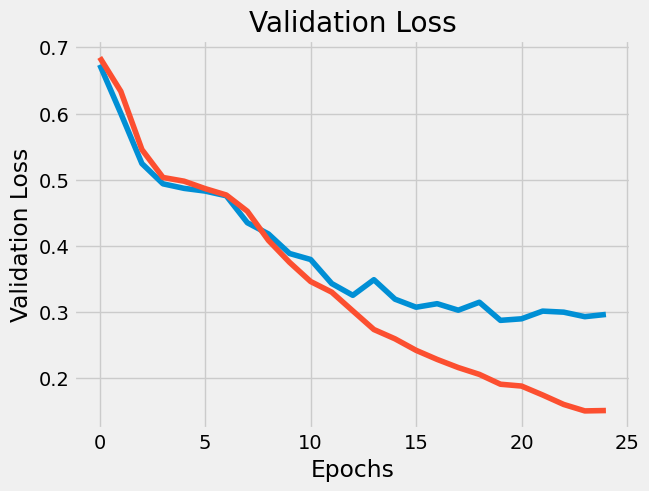

In [ ]:
plt.plot(x_epochs, y_val)
plt.plot(x_epochs, y_train)
plt.style.use('fivethirtyeight')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

In [ ]:
# Modify the location per model
model_location = "/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/DistilBERT_Saved_Models/DistilBERT best_model.pt"
checkpoint = torch.load(model_location)
# Recreate the model architecture
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6
)
# Recreate the model architecture
#model = AutoModelForSequenceClassification.from_pretrained(
#    "distilbert-base-cased",
#    num_labels=6
#)
# Load the saved weights
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
eval_dataloader = DataLoader(tokenized_validation, batch_size=len(tokenized_validation))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_batch_logits = []
y_true = []
for batch_i, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().detach().numpy()
        # output = model(**batch)
        output = model(input_ids, attention_mask=attention_mask)
        test_batch_logits.append(output.logits)
        y_true.extend(labels)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
print(len(test_batch_logits),len(eval_dataloader))
test_logits = torch.cat(test_batch_logits, dim=0)

#sanity check -> dimension 0 of your logits tensor should be same as the size of the test dataset
print(test_logits.shape,len(tokenized_validation),len(y_true))

#Convert the logits to predicted labels
y_pred = torch.argmax(test_logits, dim = 1).cpu().numpy()
print(y_true[:20])
print(y_pred[:20])

#sanity check: should have as many predictions as labels
assert len(y_pred)==len(y_true)

1 1
torch.Size([78, 6]) 78 78
[array([0, 0, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0]), array([0, 0, 1, 0, 0, 0]), array([0, 1, 0, 0, 0, 0]), array([0, 1, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0]), array([0, 0, 1, 0, 0, 1]), array([1, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 1]), array([1, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0])]
[2 1 1 4 4 1 3 1 4 3 0 1 3 0 0 0 0 1 5 4]


In [ ]:
# Load the best model
best_model_path = f"{model_path}best_model.pt"
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() # Set the model to evaluation mode

# Create a DataLoader for the test set
test_dataloader = DataLoader(tokenized_test, batch_size=batch_size)

predictions = []
pk_values = [] # To store pk values

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Predicting on test data"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Move pk to CPU and convert to numpy
        pk = batch['pk'].cpu().numpy()
        pk_values.extend(pk)


        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        predictions.extend(probs.cpu().numpy())

# Convert predictions to a DataFrame
prediction_df = pd.DataFrame(predictions, columns=[f'Topic_{i}_Prob' for i in range(6)])

# Add the original text and pk back to the prediction DataFrame
# We need to get the original text and pk from the test_df or tokenized_test dataset
# Since tokenized_test has 'pk' and we can get 'Text' from test_df using 'pk'
# Let's create a mapping from pk to Text from the original test_df
pk_to_text = test_df.set_index('pk')['Text'].to_dict()

# Add 'pk' and 'Text' to the prediction_df
prediction_df['pk'] = pk_values # Use the collected numpy array of pk values
prediction_df['Text'] = prediction_df['pk'].map(pk_to_text)

# Rearrange columns to have pk and Text first
cols = ['pk', 'Text'] + [col for col in prediction_df.columns if col not in ['pk', 'Text']]
prediction_df = prediction_df[cols]

display(prediction_df.head())

Predicting on test data:   0%|          | 0/43 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,pk,Text,Topic_0_Prob,Topic_1_Prob,Topic_2_Prob,Topic_3_Prob,Topic_4_Prob,Topic_5_Prob
0,431,"In July 2020, Cargill received a grievance aga...",0.020981,0.031171,0.537643,0.261494,0.134555,0.078990
1,432,A grievance was filed against Agropalma regard...,0.060447,0.020774,0.233134,0.113391,0.144666,0.043733
2,433,This grievance was filed by Friends of the Ear...,0.637189,0.009251,0.073488,0.018702,0.209805,0.077601
3,434,A grievance was filed against Brasil Bio Fuels...,0.043341,0.032171,0.181574,0.143283,0.577388,0.025936
4,435,A grievance was filed by Link-Ar Borneo agains...,0.222540,0.013533,0.115099,0.049918,0.324684,0.031668


In [ ]:
# Get the manual labels from the original test_df, ensuring the order matches prediction_df
# We can merge based on the 'pk' column which is present in both
evaluation_df = pd.merge(prediction_df, test_df[['pk', 'manual_label']], on='pk', how='left')

# Identify the topic probability columns
topic_prob_columns = [col for col in evaluation_df.columns if col.startswith('Topic_') and col.endswith('_Prob')]

# Get the topic indices (0 to 5) corresponding to the probability columns
topic_indices = [int(col.split('_')[1]) for col in topic_prob_columns]

# Function to get the top N predicted topic indices
def get_top_n_topics(row, topic_prob_cols, n):
    # Get the probabilities for the topic columns
    prob_values = row[topic_prob_cols].values
    # Get the indices that would sort the probabilities in descending order
    sorted_indices = np.argsort(prob_values)[::-1]
    # Get the top n indices
    top_n_indices = sorted_indices[:n]
    # Convert these indices back to the original topic numbers (0 to 5)
    top_n_topics = [topic_indices[i] for i in top_n_indices]
    return top_n_topics

# Apply the function to get the top 1 predicted topic for each row
evaluation_df['Top_1_Predicted_Topic'] = evaluation_df.apply(
    lambda row: get_top_n_topics(row, topic_prob_columns, 1)[0], axis=1 # Get the single top topic
)

# Apply the function to get the top 2 predicted topics for each row
evaluation_df['Top_2_Predicted_Topics'] = evaluation_df.apply(
    lambda row: get_top_n_topics(row, topic_prob_columns, 2), axis=1
)

# Check if the manual label matches the top 1 predicted topic
evaluation_df['Manual_Label_Matches_Top_1'] = evaluation_df.apply(
    lambda row: row['manual_label'] == row['Top_1_Predicted_Topic'], axis=1
)

# Check if the manual label is within the top 2 predicted topics
evaluation_df['Manual_Label_in_Top_2'] = evaluation_df.apply(
    lambda row: row['manual_label'] in row['Top_2_Predicted_Topics'], axis=1
)

# Display the relevant columns to show the comparison
print("Comparison of Manual Label with Top Predicted Topics (first 5 rows):")
display(evaluation_df[['pk', 'manual_label', 'Top_1_Predicted_Topic', 'Top_2_Predicted_Topics', 'Manual_Label_Matches_Top_1', 'Manual_Label_in_Top_2']].head())

# Calculate the percentage of times the manual label matches the top 1 predicted topic
percentage_matches_top_1 = evaluation_df['Manual_Label_Matches_Top_1'].mean() * 100
print(f"\nPercentage of instances where the manual label matches the Top 1 predicted topic: {percentage_matches_top_1:.2f}%")

# Calculate the percentage of times the manual label is in the top 2 predicted topics
percentage_in_top_2 = evaluation_df['Manual_Label_in_Top_2'].mean() * 100
print(f"Percentage of instances where the manual label is in the Top 2 predicted topics: {percentage_in_top_2:.2f}%")

# Optionally, display the full evaluation_df
# display(evaluation_df)

,pk,manual_label,Top_2_Predicted_Topics,Manual_Label_in_Top_2
0,431,2,"[2, 3]",True
1,432,0,"[2, 4]",False
2,433,0,"[0, 4]",True
3,434,4,"[4, 2]",True
4,435,0,"[4, 0]",True



Percentage of instances where the manual label is in the top 2 predicted topics: 60.00%


In [ ]:
evaluation_df

,pk,Text,Topic_0_Prob,Topic_1_Prob,Topic_2_Prob,Topic_3_Prob,Topic_4_Prob,Topic_5_Prob,manual_label,Top_2_Predicted_Topics,Manual_Label_in_Top_2
0,431,"In July 2020, Cargill received a grievance aga...",0.020981,0.031171,0.537643,0.261494,0.134555,0.078990,2,"[2, 3]",True
1,432,A grievance was filed against Agropalma regard...,0.060447,0.020774,0.233134,0.113391,0.144666,0.043733,0,"[2, 4]",False
2,433,This grievance was filed by Friends of the Ear...,0.637189,0.009251,0.073488,0.018702,0.209805,0.077601,0,"[0, 4]",True
3,434,A grievance was filed against Brasil Bio Fuels...,0.043341,0.032171,0.181574,0.143283,0.577388,0.025936,4,"[4, 2]",True
4,435,A grievance was filed by Link-Ar Borneo agains...,0.222540,0.013533,0.115099,0.049918,0.324684,0.031668,0,"[4, 0]",True
...,...,...,...,...,...,...,...,...,...,...,...
165,596,A grievance has been filed against PT ASM rega...,0.024235,0.035891,0.459731,0.359694,0.038993,0.097288,3,"[2, 3]",True
166,597,The grievance concerns PT SIL & SIP (Sebakis I...,0.048933,0.036774,0.234429,0.115176,0.012511,0.116013,1,"[2, 5]",False
167,598,The grievance involves a report by Rainforest ...,0.040815,0.024258,0.398810,0.145753,0.066069,0.085215,2,"[2, 3]",True
168,599,This grievance concerns the deforestation of T...,0.023900,0.045449,0.479630,0.272260,0.031717,0.105020,5,"[2, 3]",False


In [ ]:
#

In [ ]:
print('F1 Score (macro):', f1_score(y_true, y_pred, average='macro'))
print('F1 Score (weighted):', f1_score(y_true, y_pred, average='weighted'))
print('F1 Score (micro):', f1_score(y_true, y_pred, average='micro'))
print('Accuracy Score:', accuracy_score(y_true, y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['0','1','2','3','4','5']))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65        20
           1       0.95      1.00      0.98        20
           2       0.67      0.22      0.33        18
           3       0.67      1.00      0.80         8
           4       0.75      1.00      0.86         9
           5       0.50      0.67      0.57         3

    accuracy                           0.73        78
   macro avg       0.69      0.76      0.70        78
weighted avg       0.73      0.73      0.70        78



In [ ]:
model_name = "BERT"
# Load new data for classification
new_data_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/NEW_grievances_formatted.csv'
new_df = pd.read_csv(new_data_path)

print(f"Loaded {len(new_df)} entries for classification")
print("Columns in new data:", new_df.columns.tolist())

# Prepare the text data (assuming 'summary' column contains the text to classify)
# If your text column has a different name, change 'summary' below
text_column = 'Text'

# Convert to Dataset format
new_dataset = Dataset.from_pandas(new_df[[text_column]])

# Tokenize the new data
tokenized_new_data = new_dataset.map(
    lambda example: tokenizer(str(example[text_column]),  # Convert to string to handle NaN
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length)
)

# Set format to torch tensors
tokenized_new_data.set_format("torch")

# Create DataLoader for inference
inference_dataloader = DataLoader(tokenized_new_data, batch_size=batch_size)

# Run inference
model.eval()   # LOAD BEST MSODEL
all_predictions = []

with torch.no_grad():
    for batch in tqdm(inference_dataloader, desc="Classifying"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted labels
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)


# Read Classification CSV
results_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv')
results_df[f'{model_name}_label'] = all_predictions


print(f"\nClassification complete!")
print(f"Label distribution:")
# Add Label
print(results_df[f'{model_name}_label'].value_counts().sort_index())

output_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv'
results_df.to_csv(output_path, index=False)

print("\nFirst 10 classified entries:")
print(results_df[['summary', f'{model_name}_label']].head(10))

Loaded 170 entries for classification
Columns in new data: ['pk', 'Text']


Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Classifying:   0%|          | 0/43 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Classification complete!
Label distribution:
BERT_label
0     9
1    33
2    17
3    81
4    11
5    19
Name: count, dtype: int64

First 10 classified entries:
                                             summary  BERT_label
0  In July 2020, Cargill received a grievance aga...           3
1  A grievance was filed against Agropalma regard...           0
2  This grievance was filed by Friends of the Ear...           0
3  A grievance was filed against Brasil Bio Fuels...           2
4  A grievance was filed by Link-Ar Borneo agains...           0
5  A grievance was filed against Felda Global Ven...           3
6  The grievance involves allegations that First ...           2
7  An RSPO complaint has been filed by FPP agains...           2
8  A grievance was filed against Grupo Hame in Gu...           5
9  CONDEG filed a grievance report accusing Indus...           5


In [ ]:
label_map = {
    0: 'Failed Compensation/Land Rights',
    1: 'Environmental Impact',
    2: 'Administrative',
    3: 'Deforestation',
    4: 'Labour Rights',
    5: 'Illegal or Contaminated FFB'
}

results_df[f'{model_name}_topic'] = results_df[f'{model_name}_label'].map(label_map)

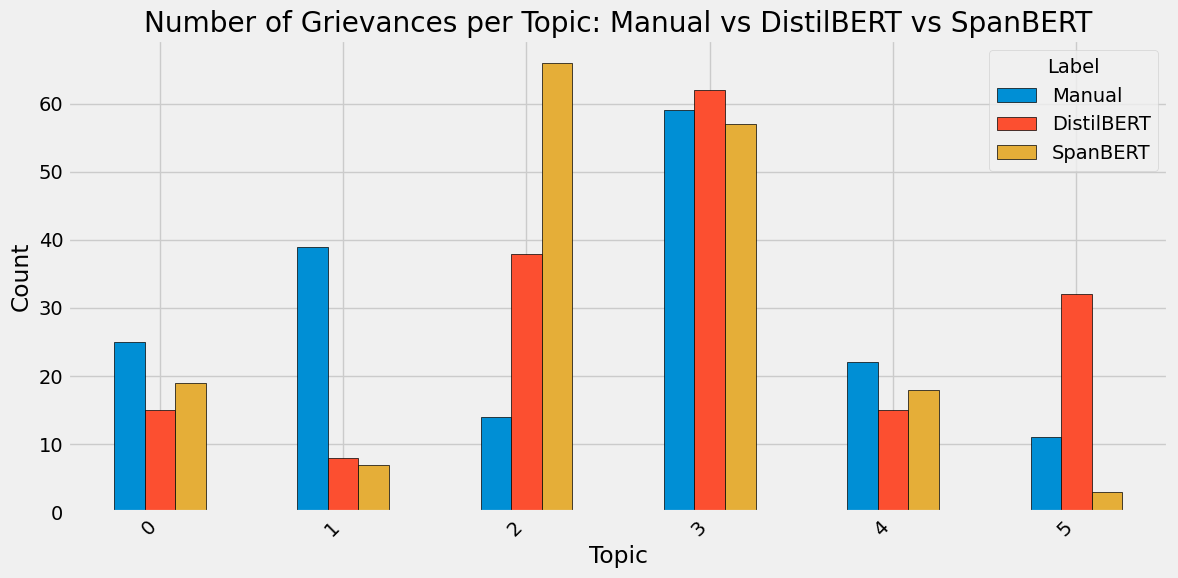

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get counts
manual_counts = results_df['manual_label'].value_counts()
distilbert_counts = results_df['DistilBERT_label'].value_counts()
spanbert_counts = results_df['SpanBERT_label'].value_counts()
electra_counts = results_df['Electra_label'].value_counts()


combined_counts = pd.DataFrame({
    'Manual': manual_counts,
    'DistilBERT': distilbert_counts,
    'SpanBERT': spanbert_counts
}).fillna(0)

combined_counts = combined_counts.sort_index()

# Plot
combined_counts.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Number of Grievances per Topic: Manual vs DistilBERT vs SpanBERT')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [ ]:
# --- Evaluation ---
true_labels = results_df['manual_label'].astype(int).values
pred_labels = np.array(all_predictions)

print("\nEvaluation on New Data:")
print("F1 Score (macro):", f1_score(true_labels, pred_labels, average='macro'))
print("F1 Score (weighted):", f1_score(true_labels, pred_labels, average='weighted'))
print("F1 Score (micro):", f1_score(true_labels, pred_labels, average='micro'))
print("Accuracy:", accuracy_score(true_labels, pred_labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=[
    'Failed Compensation/Land Rights',
    'Environmental Impact',
    'Administrative',
    'Deforestation',
    'Labour Rights',
    'Illegal or Contaminated FFB'
]))


Evaluation on New Data:
F1 Score (macro): 0.40745936367378494
F1 Score (weighted): 0.4625623342316054
F1 Score (micro): 0.45294117647058824
Accuracy: 0.45294117647058824

Classification Report:
                                 precision    recall  f1-score   support

Failed Compensation/Land Rights       0.89      0.32      0.47        25
           Environmental Impact       0.39      0.33      0.36        39
                 Administrative       0.29      0.36      0.32        14
                  Deforestation       0.48      0.66      0.56        59
                  Labour Rights       1.00      0.50      0.67        22
    Illegal or Contaminated FFB       0.05      0.09      0.07        11

                       accuracy                           0.45       170
                      macro avg       0.52      0.38      0.41       170
                   weighted avg       0.55      0.45      0.46       170

